In [1]:
# Figure S3

In [2]:
import re
import warnings

import cmaps 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from gcpy import single_panel 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 
import regionmask
import scipy.stats as stats
from scipy.stats import gmean, gstd
import seaborn as sns 
import xarray as xr 

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [4]:
# Spatial Ozone Response Comparison: c48 vs c90
variable = "SpeciesConc_O3"
variable_string = "dO3/dENOx"
CAM_c48 = tools.get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')

simulation = "w10_ref_c90"
simulation_SNOx = "w10_refSNOx_c90"
year = 2000
CAM_c90 = tools.get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year=2000, conversion_factor=1e9, resolution='c90')

In [ ]:
# Part 2: Regional Mean Ozone Response Comparison: c48 vs c90
datasets = {
    "c48": {
        "data": CAM_c48,
        "resolution": 'c48'
    },
    "c90": {
        "data": CAM_c90,
        "resolution": 'c90'
    }
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    ds_resolution = ds_info["resolution"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  # e.g. "ENA"
        results[ds_name][result_key] = tools.calculate_regional_mean_std(
                ds_data, comparison_months, region, resolution=ds_resolution
            )

In [6]:
# Part 3: Regional Mean Ozone Response Comparison: cam vs m2
c48_mean = extract_means("c48")
c90_mean = extract_means("c90")

c48_std  = extract_stds("c48")
c90_std  = extract_stds("c90")

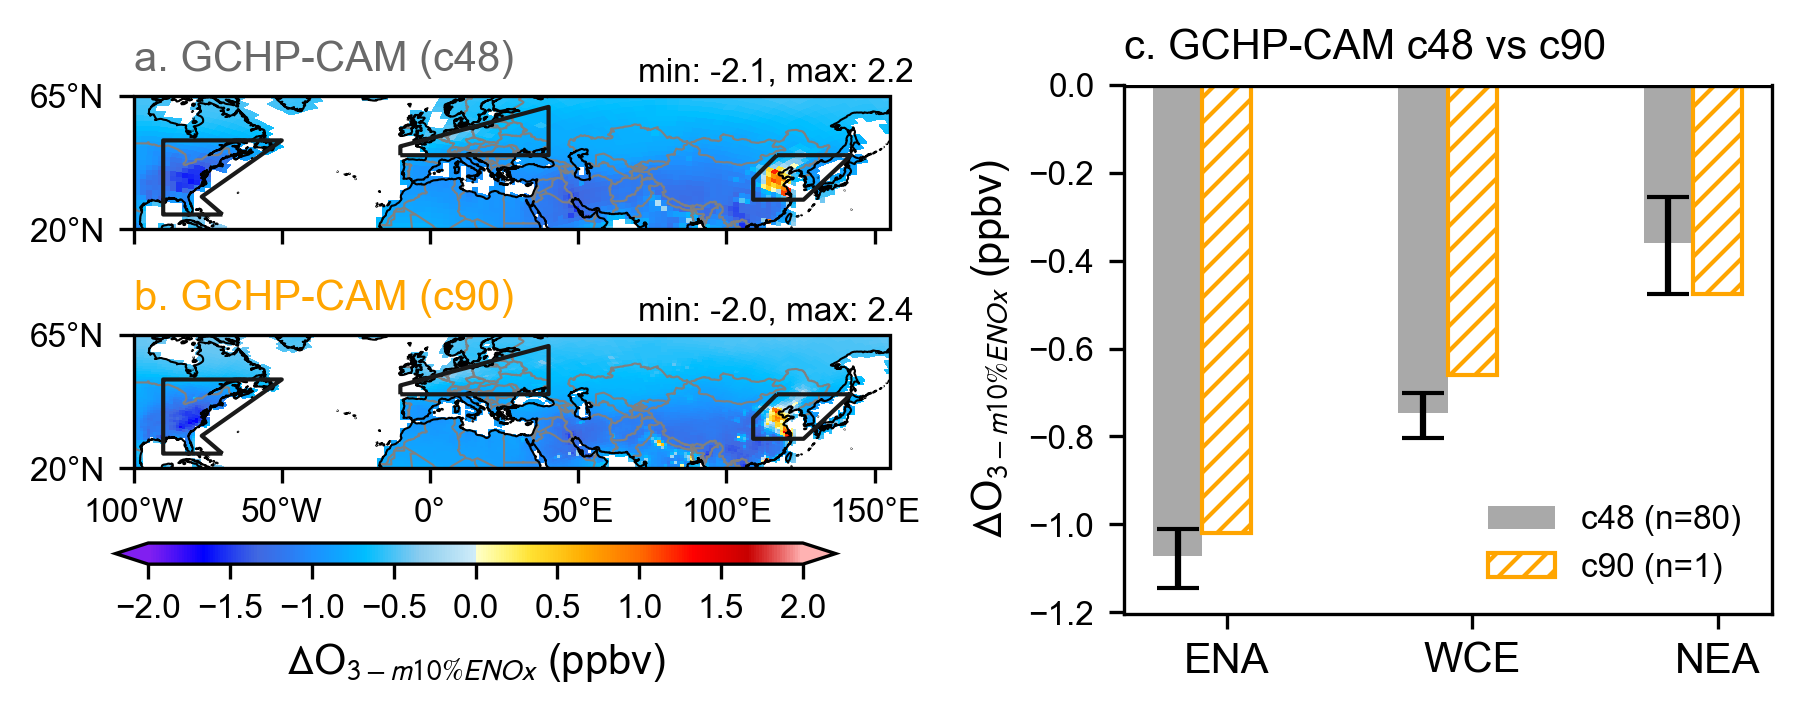

In [ ]:
# Plot figure
tools.set_matplotlib_font("Arial")
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
    
color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      
    'xtick.color': color,         
    'ytick.color': color,         
    'xtick.labelcolor': color,    
    'ytick.labelcolor': color,    
    'grid.color': color,          
    'axes.labelcolor': color,     
    'axes.titlecolor': color,     
})

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 10, 
    'axes.labelsize': 10,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})

fig_width_in = 6
fig_height_in = 2.35

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)
gs2 = GridSpec(2, 1, top=0.92, bottom=0.32, left=0.08, right=0.50, hspace = 0.30, wspace=0.05)
ax1 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs2[1, 0], projection=ccrs.PlateCarree(central_longitude=0))

gs3 = GridSpec(1, 1, top=0.90, bottom=0.15, left=0.63, right=0.99, hspace = 0.30, wspace=0.05)
ax3 = fig.add_subplot(gs3[0, 0])

#################################################################################
## Part 2: Spatial pattern of ozone response: CAM vs M2 ##
ax = [ax1, ax2]
titles= ["a. GCHP-CAM (c48)", "b. GCHP-CAM (c90)"]
colors = ['dimgrey', 'orange']
comparison_months = [4,5,6,7,8]

CAM_c48_seasonal = CAM_c48.sel(time=CAM_c48.time.dt.month.isin(comparison_months)).mean(dim=['time', 'sim'])
CAM_c90_seasonal = CAM_c90.sel(time=CAM_c90.time.dt.month.isin(comparison_months)).mean(dim=['time'])

for idx, z in enumerate([CAM_c48_seasonal, CAM_c90_seasonal,]):

    cmap = cmaps.ncl_default
    plot = single_panel(plot_vals=z, 
                ax=ax[idx], gridtype="cs", 
                comap=cmap,
                extent=(-175, 175, 0, 75), 
                vmin=-2, vmax=2,
                unit="ppbv",
                title=None,
                add_cb=False,
                )
    country_borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="50m",
        facecolor="none",
    )
    ax[idx].add_feature(country_borders, edgecolor="gray", linewidth=0.5)
    ax[idx].coastlines(color="black", linewidth=0.5)
    ax[idx].set_extent([-100, 155, 20, 65], crs=ccrs.PlateCarree())
    ax[idx].set_title(titles[idx], loc='left', size=10, color=colors[idx])

    # X-tick labels
    ax[idx].set_xticks([-100, -50, 0, 50, 100, 150])
    ax[0].set_xticklabels(
            ['', '', '', '', '', ''], fontsize=8)
    ax[1].set_xticklabels(
            ['100°W', '50°W', '0°', '50°E', '100°E', '150°E'], fontsize=8)
    
    # Y-tick labels
    ax[idx].set_yticks([20,65])
    
    ax[0].set_yticklabels(
            ['20°N', '65°N'], fontsize=8)
    ax[1].set_yticklabels(
            ['20°N', '65°N'], fontsize=8)        

    # Add boxes around the IPCC AR6 regions
    ar6 = regionmask.defined_regions.ar6.all
    ar6[5,17].plot_regions(
        ax=ax[idx],
        add_label=False,
        line_kws=dict(lw=1),
    )

    # For EAS we use a modified polygon that captures a more homogeneous response
    new_EAS = np.array([[117,45], [109,37], [109,30], [126,30],[142,45]])
    new_EAS_region = regionmask.Regions([new_EAS], name="new_EAS")
    new_EAS_region.plot_regions(add_label=False, ax=ax[idx], line_kws=dict(lw=1))

    ax[idx].annotate("min: "+"{:.1f}".format(z.min().values)+", max: "+"{:.1f}".format(z.max().values), (70,70), size=8)
    

ticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
cbar_ax = fig.add_axes([0.07, 0.22, 0.4, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(plot,  
                    cax=cbar_ax, 
                    ticks=ticks, 
                    orientation="horizontal", 
                    shrink=0.50, 
                    label=r"$\Delta$O$_{3-m10\%ENOx}$ (ppbv)",
                    extend='both'
                    )
cbar.ax.tick_params(labelsize=8)

#################################################################################
## Part 3: Regional mean barplots ozone response: CAM vs M2 ##
ax = [ax3]

bar_width = 0.15
categories = ['ENA', 'WCE', 'NEA']
x = 0.75*np.arange(len(categories))

ax[0].bar(x - bar_width, c48_mean, bar_width, yerr=tools.reshape_data(c48_std),  capsize=5, label="c48 (n=80)", color="darkgray")
ax[0].bar(x,             c90_mean, bar_width, label="c90 (n=1)", color="white", hatch='////', edgecolor="orange")
ax[0].set_ylabel(r"$\Delta$O$_{3-m10\%ENOx}$ (ppbv)", fontsize=10)
ax[0].spines[['top']].set_visible(False)
ax[0].axhline(0, color='k')
ax[0].set_xticks(x, categories, fontsize=10)
ax[0].set_title("c. GCHP-CAM c48 vs c90", loc='left', fontsize=10)
ax[0].legend(fontsize=8, frameon=False)

#################################################################################
plt.savefig("FigS3_new.png")

In [8]:
print(c48_mean)
print(c90_mean)

(array(-1.07093497), array(-0.74596307), array(-0.36065968))
(array(-1.01845706), array(-0.66056659), array(-0.47614533))
